In [40]:
%reload_ext autoreload
%autoreload 2

# Load jobs and concatenated memories 

In [41]:
from src import cpp_soft_info

In [42]:
from result_saver import SaverProvider
provider = SaverProvider()

In [43]:
from Scratch import metadata_loader

DEVICE = "ibm_sherbrooke"
DISTANCE = int(10)
ROUNDS = str(30) 
LOGICAL = str(0)

md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.drop(columns=["sampled_state", "num_qubits", "code",  "job_status", "optimization_level", "extra", "tags_xp", "tags"])
md = md[md["backend_name"] == DEVICE]

md = md.dropna(subset=["rounds"])

md = md[md["distance"]==DISTANCE]
# md = md[md["rounds"]==ROUNDS]
md = md[md["logical"]==LOGICAL]

# md

In [44]:
unique_rounds = md['rounds'].unique().tolist()
unique_rounds = [int(r) for r in unique_rounds]
unique_rounds.sort(reverse=True)
print(unique_rounds)

[10]


In [45]:
from tqdm import tqdm
import numpy as np

memories_by_rounds = {rounds: [] for rounds in unique_rounds}
for index, row in tqdm(md.iterrows(), total=md.shape[0], desc="Retrieving memory data"):
    job_id = row['job_id']
    rounds = int(row['rounds'])
    
    # Retrieve the job's memory data. Assuming provider.retrieve_job() is a function that does this.
    memory_data = provider.retrieve_job(job_id).result().get_memory()
    
    # Append the memory data to the corresponding list in the dictionary
    memories_by_rounds[rounds].append(memory_data)

for rounds in tqdm(memories_by_rounds, desc="Concatenating memory data"):
    if len(memories_by_rounds[rounds]) > 1:
        # Concatenate arrays along the first axis
        memories_by_rounds[rounds] = np.concatenate(memories_by_rounds[rounds], axis=0)
    elif len(memories_by_rounds[rounds]) == 1:
        # Just take the single array out of the list
        memories_by_rounds[rounds] = memories_by_rounds[rounds][0]

print(memories_by_rounds.keys())

shot_dict = {rounds: memories_by_rounds[rounds].shape[0] for rounds in memories_by_rounds}
print(shot_dict)

Concatenating memory data: 100%|██████████| 1/1 [00:00<00:00, 126.30it/s]

dict_keys([10])
{10: 50000}


# Initialize the code

In [46]:
import stim
import pymatching

from soft_info import get_repcode_layout, get_repcode_IQ_map
from Scratch import create_or_load_kde_grid

layout = get_repcode_layout(distance=DISTANCE, backend=provider.get_backend(DEVICE), _is_hex=True)
grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, 'cn6hk3mxhnxg008djq30', 2, 0.3, other_date=None) # rndm first sherbrooke job

# takes ~6s

In [47]:
from qiskit.result import Counts

synd_rounds = 10
memory = memories_by_rounds[synd_rounds][:]
print("memory shape:", memory.shape)

qubit_mapping = get_repcode_IQ_map(layout, synd_rounds)

counts = cpp_soft_info.get_counts(memory[:], qubit_mapping, grid_dict, processed_scaler_dict, synd_rounds)
counts = Counts(counts)

# takes 16s for 10k shots dist 40, 35 rounds 
# takes 4 s for 50k shots dist 10, 10 rounds

memory shape: (50000, 100)


In [48]:
import stim
import pymatching

max_distance = 10
d = max_distance
T = max_distance

circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
print(type(matching._matching_graph))

<class 'pymatching._cpp_pymatching.MatchingGraph'>


# Decode with spitz weight without diagonals

In [49]:
matching = matching = pymatching.Matching.from_detector_error_model(model)
cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

p_data = 6.869e-3 # mean sherbrooke ECR error
p_mixed = p_data/10000000 # Same as weighted
p_meas = 9.900e-3 # mean Readout assignment error

num_errors = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, memory, 
                                           synd_rounds, qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data=-1, p_mixed=p_mixed, p_meas=-1, common_measure=-1)
                                        
print("num_errors:", num_errors, "out of", len(memory), "shots")
         
# takes 9s

num_errors: 275 out of 50000 shots


# Decode with weight based on error_probs

In [50]:
matching = pymatching.Matching.from_detector_error_model(model)
cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

num_errors = cpp_soft_info.decode_IQ_shots_no_reweighting(matching._matching_graph, memory,
                                           synd_rounds, qubit_mapping, grid_dict,
                                           processed_scaler_dict)

print("num_errors:", num_errors, "out of", len(memory), "shots")


num_errors: 194 out of 50000 shots


In [51]:
matching = pymatching.Matching.from_detector_error_model(model)
num_errors = cpp_soft_info.decode_IQ_shots_flat_err_probs(matching._matching_graph, counts, False, "naive", memory, 
                                           synd_rounds, qubit_mapping, grid_dict, 
                                           processed_scaler_dict)

print("num_errors:", num_errors, "out of", len(memory), "shots")
# Takes 14.8s NAIVE
# Takes 8.5s SPITZ

num_errors: 194 out of 50000 shots


In [52]:
matching = pymatching.Matching.from_detector_error_model(model)
num_errors = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, memory, 
                                           synd_rounds, qubit_mapping, grid_dict, 
                                           processed_scaler_dict)
print("num_errors:", num_errors, "out of", len(memory), "shots")

# Takes 5.8s

num_errors: 175 out of 50000 shots


In [53]:
matching = pymatching.Matching.from_detector_error_model(model)

def weight_to_prob(weight):
    return 1/(1+np.exp(weight))

p_data = 6.869e-3 # mean sherbrooke ECR error
p_mixed = p_data/1 # Same as weighted
p_meas = 9.900e-3 # mean Readout assignment error

num_errors = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, memory, 
                                           synd_rounds, qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data, p_mixed, p_meas, common_measure=-1)
                                        
print("num_errors:", num_errors, "out of", len(memory), "shots")
         
# takes 5.7s

num_errors: 167 out of 50000 shots


In [54]:
matching = pymatching.Matching.from_detector_error_model(model)
# p_data = 6.869e-3 # mean sherbrooke noise
p_data = 1.15e-2
num_errors = cpp_soft_info.decode_IQ_shots(matching._matching_graph, memory, 
                                           synd_rounds, qubit_mapping, grid_dict, 
                                           processed_scaler_dict, p_data=p_data, p_mixed=p_data/1, #p_mixed=1e-80, for d=30
                                           common_measure=-1)
print("num_errors:", num_errors, "out of", len(memory), "shots")
 
# takes 24s

num_errors: 144 out of 50000 shots


# reweight matching_graph

In [55]:
cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

In [56]:
cpp_soft_info.get_edges(matching._matching_graph)

[(0,
  None,
  {'fault_ids': set(),
   'weight': 5.803552150726318,
   'error_probability': 0.0030077463015913963}),
 (0,
  1,
  {'fault_ids': set(),
   'weight': 5.650208473205566,
   'error_probability': 0.003504458349198103}),
 (0,
  9,
  {'fault_ids': set(),
   'weight': 3.7155585289001465,
   'error_probability': 0.023763395845890045}),
 (0,
  10,
  {'fault_ids': set(),
   'weight': 4.761292457580566,
   'error_probability': 0.008481986820697784}),
 (1,
  2,
  {'fault_ids': set(),
   'weight': 4.640489101409912,
   'error_probability': 0.00956068467348814}),
 (1,
  10,
  {'fault_ids': set(),
   'weight': 3.013305902481079,
   'error_probability': 0.04682835936546326}),
 (1,
  11,
  {'fault_ids': set(),
   'weight': 4.607911109924316,
   'error_probability': 0.009874154813587666}),
 (2,
  3,
  {'fault_ids': set(),
   'weight': 4.752874374389648,
   'error_probability': 0.008553075604140759}),
 (2,
  11,
  {'fault_ids': set(),
   'weight': 4.591532230377197,
   'error_probability': 

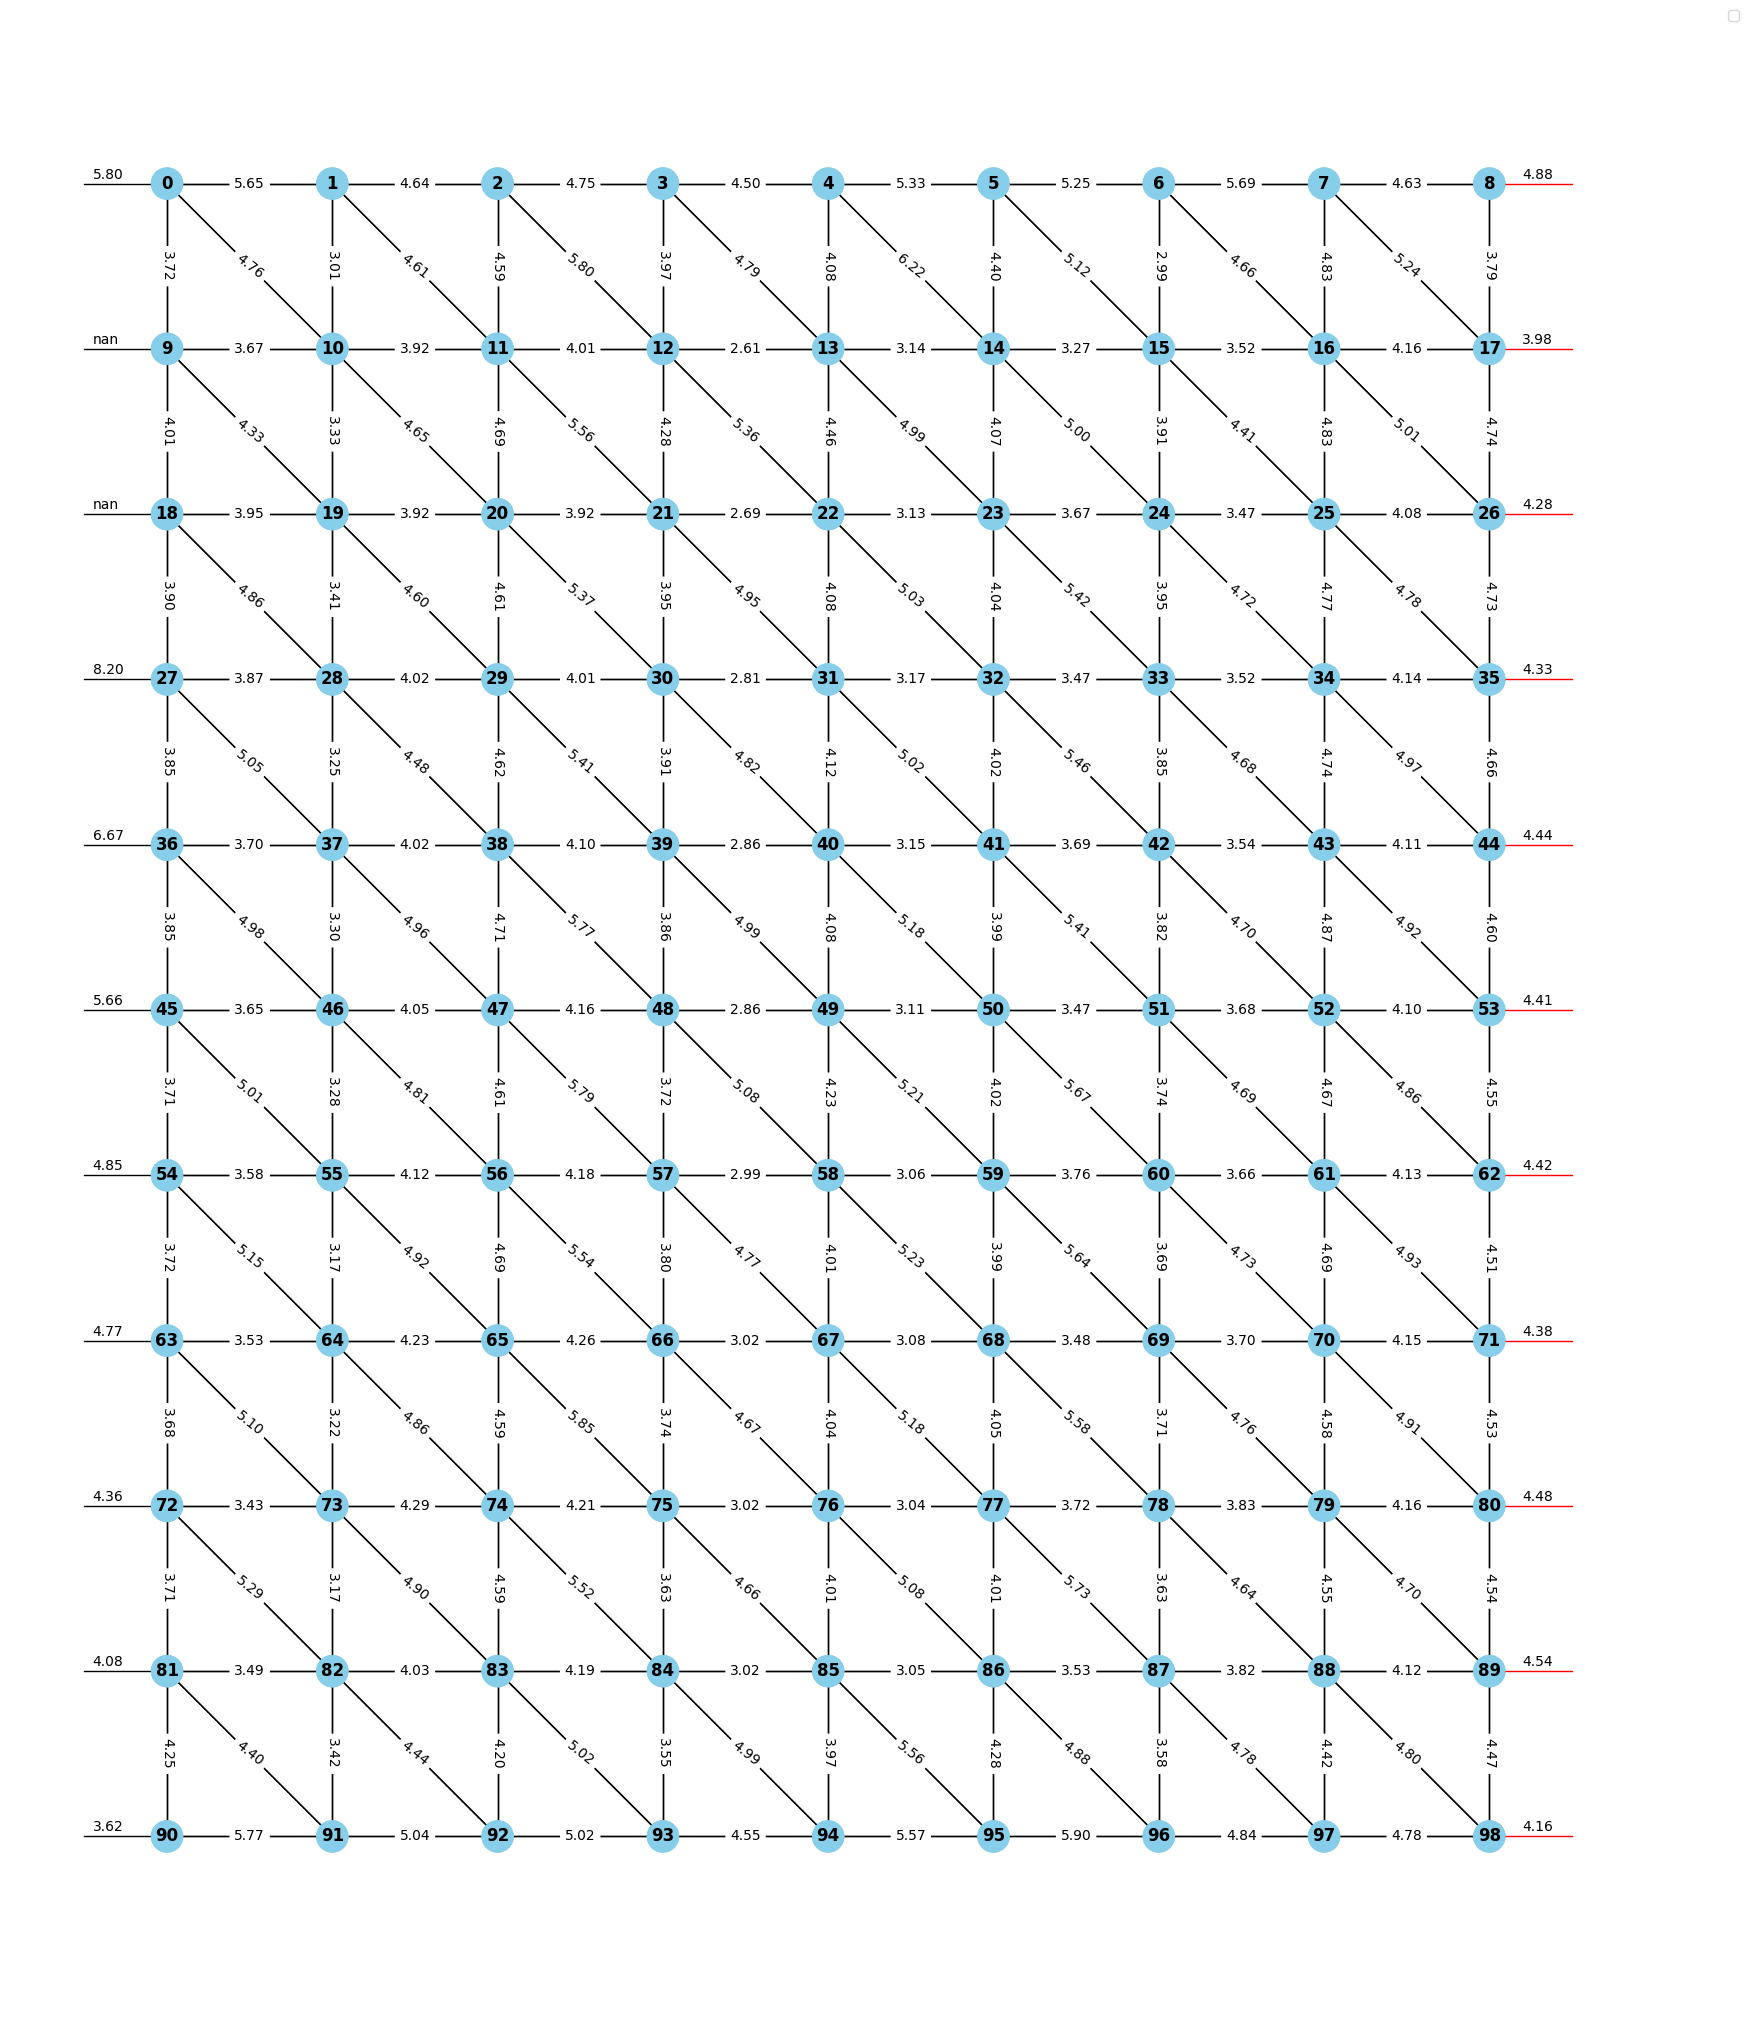

In [57]:
from soft_info import draw_matching_graph

draw_matching_graph(matching, d=DISTANCE, T=10, figsize=(20, 20))

# get edge weights CPP

In [58]:
error_probs_cpp = cpp_soft_info.calculate_spitz_error_probs(matching._matching_graph, counts, False)

probabilities_dict = {}
samples_dict = {}
for edge, error_prob in error_probs_cpp.items():
    probabilities_dict[edge] = error_prob.probability
    samples_dict[edge] = error_prob.samples

In [59]:
error_probs_cpp = cpp_soft_info.calculate_naive_error_probs(matching._matching_graph, counts, False)

probabilities_dict = {}
samples_dict = {}
for edge, error_prob in error_probs_cpp.items():
    probabilities_dict[edge] = error_prob.probability
    samples_dict[edge] = error_prob.samples

In [60]:
print(probabilities_dict)
print(samples_dict)
sorted_error_probs_cpp = {k: v for k, v in sorted(probabilities_dict.items(), key=lambda item: item[1])}
print("sorted:", sorted_error_probs_cpp)

{(0, -1): 0.019326429095653592, (0, 1): 0.006832242845061646, (0, 9): 0.026451898921235405, (0, 10): 0.014682043444027603, (1, 2): 0.011151768600801535, (1, 10): 0.05737161056309992, (1, 11): 0.014764044943820227, (2, 3): 0.010044075266994407, (2, 11): 0.012017277509301628, (2, 12): 0.008004940734934322, (3, 4): 0.012814215236101914, (3, 12): 0.02843978763711205, (3, 13): 0.01845072129955146, (4, 5): 0.005840528186896902, (4, 13): 0.025785599698027743, (4, 14): 0.007219797567090724, (5, 6): 0.007641276027412258, (5, 14): 0.01652892561983471, (5, 15): 0.011029670046600942, (6, 7): 0.005554331055763721, (6, 15): 0.060129406514948684, (6, 16): 0.015594408778400038, (7, 8): 0.010847671002937475, (7, 16): 0.010665734143462868, (7, 17): 0.007532382714705562, (8, -1): 0.019555066169123794, (8, 17): 0.02487002652519894, (9, -1): 0.03349559214129952, (9, 10): 0.03496182856094821, (9, 18): 0.021647953165275895, (9, 19): 0.02156309286937208, (10, 11): 0.026452691718147618, (10, 19): 0.04854368932

# Get edge weights QISKIT_QEC

In [13]:
from qiskit_qec.circuits import RepetitionCodeCircuit
from qiskit_qec.decoders import DecodingGraph

code = RepetitionCodeCircuit(DISTANCE, synd_rounds)
decoding_graph = DecodingGraph(code)
# takes 9s for (10,10)

In [14]:
error_probs = decoding_graph.get_error_probs(counts, LOGICAL, method="naive")
print(error_probs)

{(0, 1): 0.03333333333333333, (1, 1): 0.0032432432432432435, (0, 0): 0.002129925452609159, (3, 4): 0.04017857142857143, (0, 4): 0.02050113895216401, (0, 3): 0.009868421052631578, (1, 4): 0.03386004514672686, (5, 6): 0.0021905805038335163, (3, 6): 0.01124859392575928, (3, 5): 0.010683760683760684, (4, 6): 0.03526734926052332, (7, 8): 0.027131782945736434, (5, 8): 0.0038961038961038965, (5, 7): 0.009554140127388536, (6, 8): 0.04331210191082802, (9, 10): 0.019280205655526995, (7, 10): 0.02210663198959688, (7, 9): 0.020148462354188757, (8, 10): 0.1589561091340451, (11, 12): 0.01589103291713961, (9, 12): 0.010440835266821347, (9, 11): 0.003215434083601286, (10, 12): 0.06459948320413438, (13, 14): 0.06207674943566592, (11, 14): 0.011834319526627219, (11, 13): 0.011025358324145534, (12, 14): 0.0625, (15, 16): 0.009334889148191364, (13, 16): 0.017052375152253354, (13, 15): 0.007777777777777778, (14, 16): 0.04820766378244747, (17, 18): 0.03526734926052332, (15, 18): 0.012835472578763127, (15, 1

In [15]:
# sort the values of the error_probs dict
sorted_error_probs = {k: v for k, v in sorted(error_probs.items(), key=lambda item: item[1])}
print(sorted_error_probs)

{(0, 0): 0.002129925452609159, (20, 20): 0.0021321961620469087, (38, 38): 0.002155172413793104, (5, 6): 0.0021905805038335163, (92, 92): 0.0031746031746031746, (9, 11): 0.003215434083601286, (1, 1): 0.0032432432432432435, (5, 8): 0.0038961038961038965, (47, 47): 0.004343105320304018, (56, 56): 0.004424778761061947, (74, 74): 0.005464480874316941, (29, 29): 0.006458557588805166, (92, 93): 0.006486486486486486, (96, 97): 0.007462686567164178, (83, 83): 0.007583965330444203, (87, 97): 0.007594936708860759, (65, 65): 0.007616974972796517, (13, 15): 0.007777777777777778, (90, 100): 0.008168028004667444, (39, 49): 0.008323424494649227, (15, 16): 0.009334889148191364, (5, 7): 0.009554140127388536, (84, 94): 0.009673518742442563, (0, 3): 0.009868421052631578, (97, 98): 0.010078387458006719, (40, 49): 0.010101010101010102, (67, 76): 0.010215664018161182, (9, 12): 0.010440835266821347, (3, 5): 0.010683760683760684, (11, 13): 0.011025358324145534, (3, 6): 0.01124859392575928, (93, 94): 0.01165254